In [11]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import scipy.stats as stats
from math import isclose
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:f}'.format})


import time
import timeit   
%pylab inline
from matplotlib import cm
from IPython.display import HTML
_SAVE_GIFS= False
rcParams.update({'axes.labelsize': 17.,
              'font.size': 12.,
              'legend.fontsize': 17.,
              'xtick.labelsize':15.,
              'ytick.labelsize':15.,
              'text.usetex': _SAVE_GIFS,
              'figure.figsize': [10,10],
              'xtick.major.size' : 4,
              'ytick.major.size' : 4,
              'xtick.minor.size' : 2,
              'ytick.minor.size' : 2,
              'legend.numpoints':1})

Populating the interactive namespace from numpy and matplotlib


### STEP 1: LOADING DATASET

In [27]:
'''
STEP 1: LOADING DATASET
'''

N = 1001
xv = 0
x_min = -15.
x_max = 15.
x_range = x_max - x_min
v_min = -5.
v_max = 5.
v_range = v_max - v_min


train_array = np.load('/Users/JawanHaider/Desktop/Research/1500/Code/Data/varpert_spiralsech2_rho_train_2000xv.npy')

train_in_mean = np.transpose(train_array[0, :, :, :-1].mean(axis=2))
mean_sub = np.transpose(train_array[0, :, :, :-1]) - train_in_mean
train_in_var = np.transpose(train_array[0, :, :, :-1].std(axis=2))
train_array[0, :, :, :-1] = np.transpose(mean_sub/   train_in_var    )

train_out_mean = np.transpose(train_array[1, :, :, :-1].mean(axis=2))
mean_sub = np.transpose(train_array[1, :, :, :-1]) - train_out_mean
train_out_var = np.transpose(train_array[1, :, :, :-1].std(axis=2))
train_array[1, :, :, :-1] = np.transpose(mean_sub/   train_out_var    )

train_array = np.swapaxes(train_array, 1, 2)
train_tensor = torch.Tensor(train_array)
train_dataset = TensorDataset(train_tensor[0, :, :, :], train_tensor[1, :, :, :-1]) # create your datset



test_array = np.load('/Users/JawanHaider/Desktop/Research/1500/Code/Data/varpert_spiralsech2_rho_test_1000xv.npy')

test_in_mean = np.transpose(test_array[0, :, :, :-1].mean(axis=2))
mean_sub = np.transpose(test_array[0, :, :, :-1]) - test_in_mean
test_in_var = np.transpose(test_array[0, :, :, :-1].std(axis=2))
test_array[0, :, :, :-1] = np.transpose(mean_sub/   test_in_var    )

test_out_mean = np.transpose(test_array[1, :, :, :-1].mean(axis=2))
mean_sub = np.transpose(test_array[1, :, :, :-1]) - test_out_mean
test_out_var = np.transpose(test_array[1, :, :, :-1].std(axis=2))
test_array[1, :, :, :-1] = np.transpose(mean_sub/   test_out_var    )

test_array = np.swapaxes(test_array, 1, 2)
test_tensor = torch.Tensor(test_array)
test_dataset = TensorDataset(test_tensor[0, :, :, :], test_tensor[1, :, :, :-1]) # create your datset



deg_freedom = train_tensor[0, 0, :, 0].size()[0]
train_size = train_tensor[0, :, 0, 0].size()[0]
test_size = test_tensor[0, :, 0, 0].size()[0]
num_datapoints = train_tensor[0, 0, 0, :].size()[0]-1
train_amp = np.unique(train_array[0, :, 0, -1])


print(deg_freedom, train_size, test_size, num_datapoints)
print(train_amp.size)
# tst = np.transpose( np.transpose(train_array[0, :, :, :])*np.transpose(train_in_var)+np.transpose(train_in_mean) )
# print(tst.shape)
# print(tst[999, 1, :])

2 2000 1000 60
40


### STEP 2: MAKING DATASET ITERABLE

In [28]:
'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
num_batches = train_size/batch_size
print(num_batches)

n_iters = 15000

num_epochs = n_iters / num_batches
print(num_epochs)
num_epochs = int(num_epochs)

train_loader = DataLoader(dataset=train_dataset, 
                            batch_size=batch_size, 
                            shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                            batch_size=batch_size, 
                            shuffle=False)

20.0
750.0


### STEP 3: CREATING MODEL CLASS

In [5]:
'''
STEP 3: CREATE MODEL CLASS
'''

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function 1: 784 --> 100
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.Tanh()
        
        # Linear function 2: 100 --> 100
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.relu2 = nn.Tanh()

        # Linear function 3: 100 --> 100
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.relu3 = nn.Tanh()

        # Linear function 4: 100 --> 100
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 4
        self.relu4 = nn.Tanh()
        
        # Linear function 5 (readout): 100 --> 10
        self.fc5 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.relu2(out)
        
        # Linear function 3
        out = self.fc3(out)
        # Non-linearity 3
        out = self.relu3(out)

        # Linear function 4
        out = self.fc4(out)
        # Non-linearity 4
        out = self.relu4(out)
        
        # Linear function 5 (readout)
        out = self.fc5(out)

        return out

### STEP 4: INSTANTIATING MODEL CLASS

In [6]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''

input_dim = 2*num_datapoints+1
hidden_dim = input_dim*10
output_dim = input_dim-1
print(input_dim, hidden_dim, output_dim)

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

121 1210 120


### STEP 5: INSTANTIATING LOSS CLASS

In [7]:
'''
STEP 5: INSTANTIATE LOSS CLASS
'''

criterion = nn.MSELoss()

### STEP 6: INSTANTIATING OPTIMIZER CLASS

In [8]:
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''

learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### STEP 7: TRAINING THE MODEL

In [18]:
'''
STEP 7: TRAIN THE MODEL
'''

iter = 0
train_predictions = np.empty((2, output_dim))
# all_true_outputs = np.empty((0, output_dim))
# all_model_outputs = np.empty((0, output_dim))

start = time.time()

for epoch in range(num_epochs):
    # print("Epoch:", epoch)
    for i, (inputs, true_outputs) in enumerate(train_loader):
        # print("i:", i)
        
        inputs = Variable(inputs.view(-1, input_dim+1))
        temp = inputs.detach().numpy()
        temp = np.delete(temp, 60, axis=1)
        inputs = torch.tensor(temp)
        inputs = Variable(inputs)

        true_outputs = Variable(true_outputs.view(-1, output_dim))
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        model_outputs = model(inputs)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(model_outputs, true_outputs)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 5000 == 0:


            # Calculate Train Accuracy         
            correct = 0
            total = 0
            # Iterate through train dataset
            for inputs, true_outputs in train_loader:
                inputs = Variable(inputs.view(-1, input_dim+1))
                temp = inputs.detach().numpy()
                temp = np.delete(temp, 60, axis=1)
                inputs = torch.tensor(temp)
                inputs = Variable(inputs)

                true_outputs = Variable(true_outputs.view(-1, output_dim))

                # Forward pass only to get logits/output
                model_outputs = model(inputs)

                # Total number of true_outputs
                total += true_outputs.nelement()

                nppredicted = model_outputs.detach().numpy()
                nptrue = true_outputs.numpy()
                size = np.size(nptrue, 0)

                for j in range(size):
                    predicted = nppredicted[j,:]
                    true = nptrue[j,:]

                    # Total correct predictions
                    correct += (np.isclose(predicted, true, rtol=0.2)).sum()
            
            train_predictions[0, :] = true
            train_predictions[1, :] = predicted

            train_accuracy = 100 * correct / total




            # Calculate Test Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for inputs, true_outputs in test_loader:
                inputs = Variable(inputs.view(-1, input_dim+1))
                temp = inputs.detach().numpy()
                temp = np.delete(temp, 60, axis=1)
                inputs = torch.tensor(temp)
                inputs = Variable(inputs)

                true_outputs = Variable(true_outputs.view(-1, output_dim))

                # Forward pass only to get logits/output
                model_outputs = model(inputs)

                # Total number of true_outputs
                total += true_outputs.nelement()

                nppredicted = model_outputs.detach().numpy()
                nptrue = true_outputs.numpy()
                size = np.size(nptrue, 0)

                for j in range(size):
                    predicted = nppredicted[j,:]
                    true = nptrue[j,:]

                    # Total correct predictions
                    correct += (np.isclose(predicted, true, rtol=0.2)).sum()
            
            test_accuracy = 100 * correct / total




            # Print Loss
            print('Iteration: {}. Loss: {}. Train Accuracy: {}. Test Accuracy: {}'.format(iter, loss.data, train_accuracy, test_accuracy))

end = time.time()

print("--- %s seconds ---" % (end - start))

Iteration: 5000. Loss: 0.02320478856563568. Train Accuracy: 79.0075. Test Accuracy: 80.5
Iteration: 10000. Loss: 0.022959144786000252. Train Accuracy: 79.09666666666666. Test Accuracy: 80.75
Iteration: 15000. Loss: 0.02183397486805916. Train Accuracy: 79.10333333333334. Test Accuracy: 80.58333333333333
--- 427.19210290908813 seconds ---


### STEP 8: TESTING THE MODEL 

In [29]:
'''
STEP 8: TESTING THE MODEL
'''

input_array = np.empty((0, input_dim))
output_array = np.empty((0, output_dim))
target_array = np.empty((0, output_dim))

start = time.time()

iter = 0
# Iterate through test dataset
for inputs, true_outputs in test_loader:
    iter += 1
    
    inputs = Variable(inputs.view(-1, input_dim+1))
    temp = inputs.detach().numpy()
    temp = np.delete(temp, 60, axis=1)
    inputs = torch.tensor(temp)
    inputs = Variable(inputs)
    
    true_outputs = Variable(true_outputs.view(-1, output_dim))

    # Forward pass only to get logits/output
    model_outputs = model(inputs)

    loss = criterion(model_outputs, true_outputs)
    
    npinputs = inputs.detach().numpy()
    input_array = np.concatenate((input_array, npinputs))

    npoutputs = model_outputs.detach().numpy()
    output_array = np.concatenate((output_array, npoutputs))

    nptargets = true_outputs.detach().numpy()
    target_array = np.concatenate((target_array, nptargets))
    
    print('Batch: {}. Loss: {}.'.format(iter, loss.data))

end = time.time()

print(f"\nRuntime of the program is {end - start} seconds")

Batch: 1. Loss: 0.02033093199133873.
Batch: 2. Loss: 0.019988760352134705.
Batch: 3. Loss: 0.02132885530591011.
Batch: 4. Loss: 0.020590633153915405.
Batch: 5. Loss: 0.02144801802933216.
Batch: 6. Loss: 0.020717667415738106.
Batch: 7. Loss: 0.021380770951509476.
Batch: 8. Loss: 0.020429840311408043.
Batch: 9. Loss: 0.022024421021342278.
Batch: 10. Loss: 0.022135764360427856.

Runtime of the program is 0.09166193008422852 seconds


### STEP 9: DENORMALIZING THE DATA

In [30]:
'''
STEP 9: DENORMALIZING THE DATA
'''

target_array = np.reshape(target_array, (test_size, 2, 60))
output_array = np.reshape(output_array, (test_size, 2, 60))
amp = input_array[:, -1]
test_amp = np.unique(amp)
input_array = np.delete(input_array, -1, axis=1)
input_array = np.reshape(input_array, (test_size, 2, 60))


target_array = np.transpose(target_array) * np.transpose(test_out_var) 
target_array = np.transpose( target_array + np.transpose(test_out_mean) )
target_array[target_array < 0] = 0

output_array = np.transpose(output_array) * np.transpose(test_out_var)
output_array = np.transpose( output_array + np.transpose(test_out_mean) )
output_array[output_array < 0] = 0

input_array = np.transpose(input_array) * np.transpose(test_in_var)
input_array = np.transpose( input_array + np.transpose(test_in_mean) )
input_array[input_array < 0] = 0

### STEP 10: PLOTTING THE RESULTS

In [31]:
print(train_amp, "\n\n", test_amp)

[0.000000 0.300000 0.600000 0.900000 1.200000 1.500000 1.800000 2.100000
 2.400000 2.700000 3.000000 3.300000 3.600000 3.900000 4.200000 4.500000
 4.800000 5.100000 5.400000 5.700000 6.000000 6.300000 6.600000 6.900000
 7.200000 7.500000 7.800000 8.100000 8.400000 8.700000 9.000000 9.300000
 9.600000 9.900000 10.200000 10.500000 10.800000 11.100000 11.400000
 11.700000] 

 [0.000000 0.150000 0.300000 0.450000 0.600000 0.750000 0.900000 1.050000
 1.200000 1.350000]


Text(0, 0.5, '$\\rho(x)$')

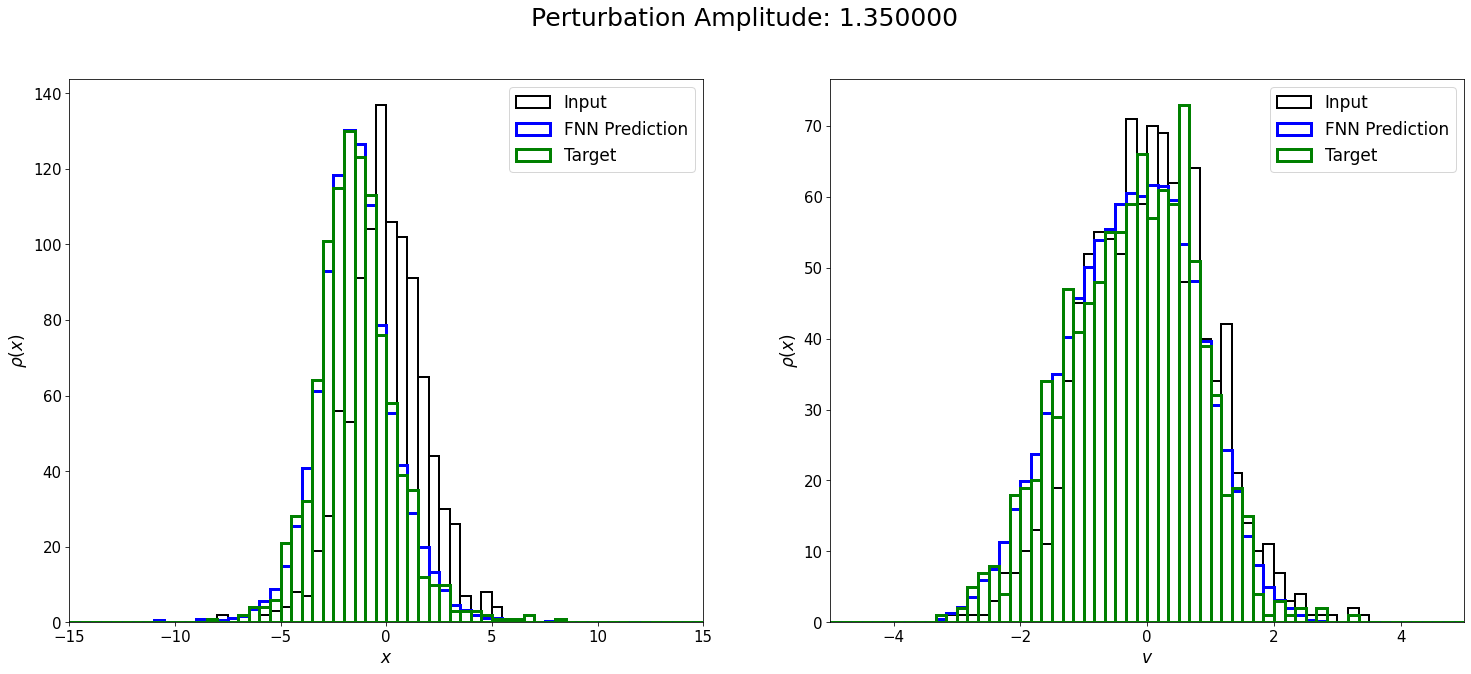

In [33]:
'''
STEP 10: PLOTTING THE RESULTS
'''

fig, (ax1, ax2) = subplots(1, 2, figsize=(25,10))

datapoint = 999
xv = 0
width = x_range/num_datapoints
bins = np.linspace(x_min, x_max, num=num_datapoints, endpoint=False)

fig.suptitle('Perturbation Amplitude: %f' %amp[datapoint], fontsize=25)

ax1.bar(bins, input_array[datapoint, xv, :], width=width, lw=2., ec='k', fill=False, align='edge', label='Input')
ax1.bar(bins, output_array[datapoint, xv, :], width=width, lw=3., ec='b', fill=False, align='edge', label='FNN Prediction')
ax1.bar(bins, target_array[datapoint, xv, :], width=width, lw=3., ec='g', fill=False, align='edge', label='Target')
ax1.legend()
ax1.set_xlim(x_min, x_max)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$\rho(x)$')

xv = 1
width = v_range/num_datapoints
bins = np.linspace(v_min, v_max, num=num_datapoints, endpoint=False)

ax2.bar(bins, input_array[datapoint, xv, :], width=width, lw=2., ec='k', fill=False, align='edge', label='Input')
ax2.bar(bins, output_array[datapoint, xv, :], width=width, lw=3., ec='b', fill=False, align='edge', label='FNN Prediction')
ax2.bar(bins, target_array[datapoint, xv, :], width=width, lw=3., ec='g', fill=False, align='edge', label='Target')
ax2.legend()
ax2.set_xlim(v_min, v_max)
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$\rho(x)$')

### STEP 11: MEASURING PERFORMANCE

In [50]:
'''
STEP 11: MEASURING PERFORMANCE
'''

output_array_flt = output_array.flatten()
target_array_flt  = target_array.flatten()

rel_err = np.empty(test_size)

for i in range(test_size):
    if target_array_flt[i]==0 or output_array_flt[i]!=0:
        rel_err[i] = 0
    else:
        rel_err[i] = np.abs(output_array_flt[i]-target_array_flt[i])/(target_array_flt[i])

print("Relative error:", rel_err.mean()*100, "%")

xv = 1
# print(stats.kstest(output_array[200, xv, :], target_array[200, xv, :]))
# print(stats.ks_2samp(output_array[200, xv, :], target_array[200, xv, :]))

kl_div = stats.entropy( np.transpose(output_array[2, xv, :]), qk=np.transpose(target_array[2, xv, :]) )
print(kl_div)
print(output_array[2, xv, :])
print(target_array[2, xv, :])

Relative error: 9.4 %
[0.031571 0.022652 inf inf inf inf inf 0.022579 inf inf inf inf 0.024047
 0.017128 0.018597 0.019363 0.024868 0.030523 0.017430 0.020177 0.022233
 0.026732 inf inf inf 0.020125 0.023460 0.028068 inf inf 0.019403 0.037611
 0.028416 0.021943 0.022991 0.024711 0.022246 0.028257 0.029428 0.030942
 inf inf inf inf inf 0.028965 0.027165 inf 0.017037 inf inf inf inf inf
 0.022694 0.027655 0.028388 0.021757 0.020987 inf 0.030315 inf 0.028769
 0.028405 0.019286 0.023641 0.017620 inf inf 0.016911 0.023471 0.027845
 0.025803 inf 0.018875 inf 0.025441 inf inf 0.023918 0.019050 inf 0.032318
 0.024729 0.021901 inf 0.019862 inf inf inf 0.019462 0.021912 inf 0.018215
 0.018959 inf inf 0.025928 inf 0.024189 inf inf 0.027670 inf 0.038296 inf
 0.017330 inf inf inf inf 0.024712 0.025148 0.014439 inf inf inf 0.024564
 inf 0.015666 inf 0.024168 inf 0.018491 inf inf 0.027107 0.021413 inf
 0.013222 inf inf inf 0.017964 0.024336 inf inf 0.033091 inf 0.023796
 0.021347 0.025370 inf 0.01963